# Scop3P

A comprehensive database of human phosphosites within their full context. Scop3P integrates sequences (UniProtKB/Swiss-Prot), structures (PDB), and uniformly reprocessed phosphoproteomics data (PRIDE) to annotate all known human phosphosites. 

Scop3P, available at https://iomics.ugent.be/scop3p, presents a unique resource for visualization and analysis of phosphosites and for understanding of phosphosite structure–function relationships.

Scop3P DOI: https://doi.org/10.1021/acs.jproteome.0c00306

## Dependencies

In [1]:
%%capture
!pip install pandas matplotlib

In [26]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", font_scale=1)

## Target protein

In [3]:
target_accession = "O00571"

## API Request

These functions make GET requests to UniProt and SCOP3P API endpoints for a given protein accession ID and returns the responses. It uses the requests library for HTTP requests.

- Fetch sequence of amino acids from UniProt: Returns the protein sequence in string format.
- Fetch modifications from SCOP3P: Returns the modifications in JSON format.

### Fetch protein sequence from UniProt

In [4]:
def fetch_sequence_aminoacids(accession):
    BASE_URL = f"http://uniprot.org/uniprotkb/{target_accession}.fasta"
    url = f'{BASE_URL}?accession={accession}'
    response = requests.get(url)
    if response.status_code == 200:
        raw_fasta_sequence = response.content.decode("utf-8")
    else:
        raw_fasta_sequence = ""
    
    lines = raw_fasta_sequence.split('\n')
    protein_id = str(lines[0])
    amino_acids = "".join([str(l) for l in lines[1:]])
    
    return protein_id, amino_acids

In [5]:
target_protein_id, target_amino_acids = fetch_sequence_aminoacids(target_accession)
target_length = len(target_amino_acids)

print(f"{target_accession}: {target_length} amino acids")

O00571: 662 amino acids


### Fetch modifications from Scop3P

In [6]:
def fetch_protein_modifications(accession):
    """
    Fetches protein modifications for a given UniProt ID.

    Parameters:
    accession (str): UniProt ID of the protein.

    Returns:
    dict: A dictionary containing protein modifications.
    """
    BASE_URL = "https://iomics.ugent.be/scop3p/api/modifications"
    url = f'{BASE_URL}?accession={accession}'
    headers = {'accept': 'application/json'}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        return None

In [10]:
scop3P_results = fetch_protein_modifications(target_accession)

protein_name = scop3P_results['proteinName']
entry_name = scop3P_results['entryName']
accession = scop3P_results['accession']
url = scop3P_results['url']
modifications = scop3P_results['modifications']

assert target_accession == accession, "The response's accession doesn't match with the requested one"

In [13]:
print("""
--------------------------------------------------------------------------------
Scop3P: A Comprehensive Resource of Human Phosphosites within Their Full Context
--------------------------------------------------------------------------------

Here are some details for your protein {0}

Entry name: {1}
Protein names: {2}

Phospho-sites found: {3} entries.

Full entry available on Scop3P website: {4}

--------------------------------------------------------------------------------
""".format(accession, entry_name, protein_name, len(modifications),url))


--------------------------------------------------------------------------------
Scop3P: A Comprehensive Resource of Human Phosphosites within Their Full Context
--------------------------------------------------------------------------------

Here are some details for your protein O00571

Entry name: DDX3X_HUMAN
Protein names: ATP-dependent RNA helicase DDX3X (EC 3.6.4.13) (DEAD box protein 3, X-chromosomal) (DEAD box, X isoform) (Helicase-like protein 2) (HLP2)

Phospho-sites found: 37 entries.

Full entry available on Scop3P website: https://iomics.ugent.be/scop3p/index?protein=O00571

--------------------------------------------------------------------------------



## Data parsing

For parsing the JSON as a table, we'll use pandas library.

In [34]:
def get_modification_table(modifications):
    """
    Displays the protein modifications in a pandas DataFrame.

    Parameters:
    modifications (list): A list of dictionaries, each representing a protein modification.
    """
    df = pd.DataFrame(modifications)
    df = df[['residue', 'name', 'evidence', 'position', 'source', 'reference', 'functionalScore',\
             'specificSinglyPhosphorylated']]
    df=df.drop('reference',axis=1)
    df.columns=['Modified_residue', 'Modification_name', 'UniProt_evidence', 'Modified_position',\
                'Source', 'functionalScore', 'Singly phosphorylted in peptide?']
    
#     df['Modified_residue']=df['Modified_residue'].str.replace('Phospho','p')
    
    return df 
    
modification_table = get_modification_table(modifications)

display(modification_table)

,Modified_residue,Modification_name,UniProt_evidence,Modified_position,Source,functionalScore,Singly phosphorylted in peptide?
0,PhosphoY,phosphorylation,None,53,PRIDE,0.389343,1
1,PhosphoS,phosphorylation,None,61,PRIDE,0.283915,1
2,PhosphoY,phosphorylation,None,69,PRIDE,0.597372,1
3,PhosphoS,phosphorylation,None,70,PRIDE,0.360107,1
4,PhosphoS,phosphorylation,None,71,PRIDE,0.292276,1
5,PhosphoS,phosphorylation,None,74,PRIDE,0.275843,1
6,PhosphoS,phosphorylation,Combined,82,"UP, PRIDE",0.436827,0
7,PhosphoS,phosphorylation,None,83,PRIDE,0.452826,0
8,PhosphoS,phosphorylation,Combined,86,"UP, PRIDE",0.370970,1
9,PhosphoS,phosphorylation,Combined,90,"UP, PRIDE",0.606562,1


## Plotting Results

For plotting, we want to visualize the distribution of functional scores for the protein modifications and the phospho-sites per residue. We'll use matplotlib library.

### Functional scores

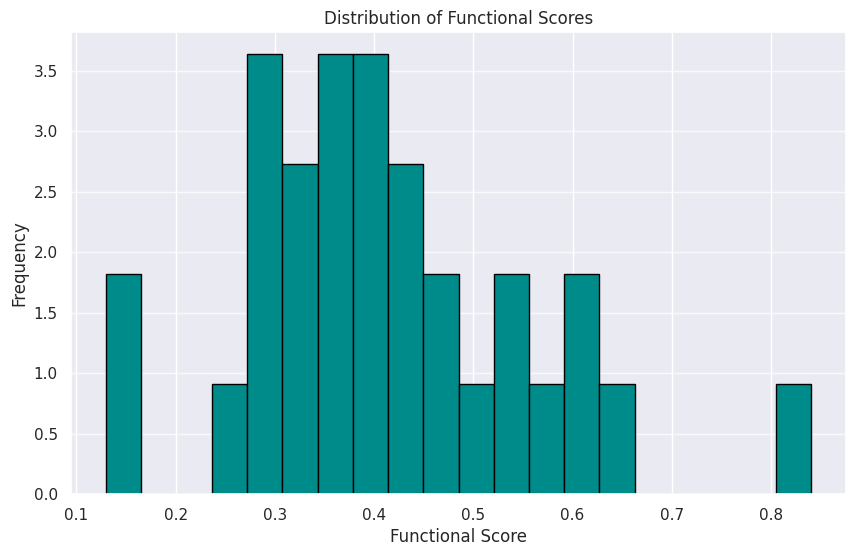

In [35]:
def plot_functional_scores(modifications):
    """
    Plots the distribution of functional scores for protein modifications.

    Parameters:
    modifications (list): A list of modification dictionaries.
    """
    # Filter out modifications with a null functionalScore
    functional_scores = modifications['functionalScore']

    plt.figure(figsize=(10, 6))
    plt.hist(functional_scores, density=True, bins=20, color='darkcyan', edgecolor='black')
    plt.title('Distribution of Functional Scores')
    plt.xlabel('Functional Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

plot_functional_scores(modification_table)

### Phospho-sites per position

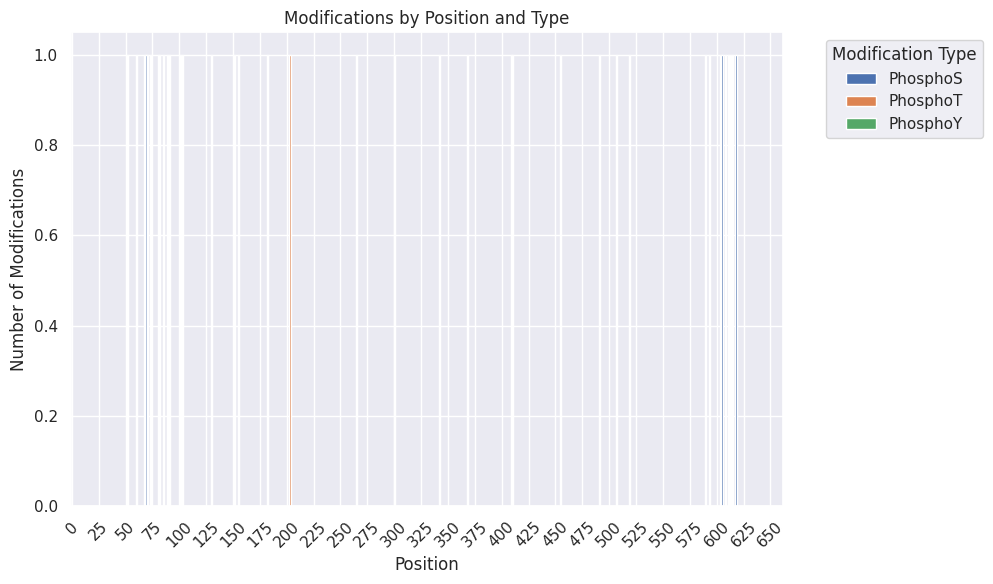

In [37]:
def plot_modifications_by_position(df, sequence_length, position_col='Modified_position', name_col='Modified_residue', label_interval=25):
    """
    Plots a bar plot showing the number of modifications at each position in the protein sequence,
    grouped by modification name, covering the entire sequence length.

    Parameters:
    df (pd.DataFrame): DataFrame containing the modifications data.
    sequence_length (int): The total length of the protein sequence.
    position_col (str): Name of the column in df that represents the position of the modification.
    name_col (str): Name of the column in df that represents the name of the modification.
    """
    # Group by position and name, then count occurrences
    modification_counts = df.groupby([position_col, name_col]).size().reset_index(name='counts')
    
    # Pivot the data for plotting
    pivot_df = modification_counts.pivot(index=position_col, columns=name_col, values='counts').fillna(0)
    
    # Ensure all positions are represented up to the sequence length
    all_positions = pd.DataFrame(index=np.arange(1, sequence_length + 1))
    pivot_df = all_positions.join(pivot_df).fillna(0)
    
    # Plot
    pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6), width=1)
    plt.title('Modifications by Position and Type')
    plt.xlabel('Position')
    plt.ylabel('Number of Modifications')
    
    # Reduce the number of x-axis labels for better readability
    ticks_to_show = np.arange(0, sequence_length + 1, label_interval)
    plt.xticks(ticks=ticks_to_show, labels=ticks_to_show, rotation=45)
    
    plt.legend(title='Modification Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend

    plt.show()


plot_modifications_by_position(modifications_table, target_length)